In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from PIL import Image
import time
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
np.random.seed(0)

### 卷积实现

In [4]:
def from_image(infilename):
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="int32")
    return data

def to_image(npdata, grey=False, save_path=None) :
    mode = "L" if grey else "RGB"
    outimg = Image.fromarray(np.asarray(npdata, dtype="uint8"), mode)
    if save_path:
        outimg.save(save_path)
    return outimg

In [5]:
def get_padding(inputs, ks, mode="SAME"):
    """
    params: inputs (input array)
    params: ks (kernel size) [p, q]
    return: padding list [n,m,j,k] in different modes
    """
    pad = None
    if mode == "FULL":
        pad = [ks[0] - 1, ks[1] - 1, ks[0] - 1, ks[1] - 1]
    elif mode == "VALID":
        pad = [0, 0, 0, 0]
    elif mode == "SAME":
        pad = [(ks[0] - 1) // 2, (ks[1] - 1) // 2, 
               (ks[0] - 1) // 2, (ks[1] - 1) // 2]
        if ks[0] % 2 == 0:
            pad[2] += 1
        if ks[1] % 2 == 0:
            pad[3] += 1
    else: 
        print("Invalid mode")
    return pad


In [6]:
def conv(inputs, kernel, stride, mode="SAME"):
    ks = kernel.shape[:2]
    # get_padding
    pad = get_padding(inputs, ks, mode="SAME")
    padded_inputs = np.pad(inputs, pad_width=((pad[0], pad[2]), (pad[1], pad[3]), (0, 0)), mode="constant")

    height, width, channels = inputs.shape
    out_width = int((width + pad[0] + pad[2] - ks[0]) / stride + 1)
    out_height = int((height + pad[1] + pad[3] - ks[1]) / stride + 1)
    
    outputs = np.empty(shape=(out_height, out_width))
    for r, y in enumerate(range(0, padded_inputs.shape[0]-ks[1]+1, stride)):
        for c, x in enumerate(range(0, padded_inputs.shape[1]-ks[0]+1, stride)):
            outputs[r][c] = np.sum(padded_inputs[y:y+ks[1], x:x+ks[0], :] * kernel)
    return outputs

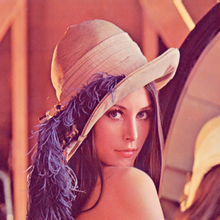

In [7]:
inputs = from_image("./Lenna_test_image.png")
to_image(inputs, save_path="./plots/conv/lenna_origin.png")

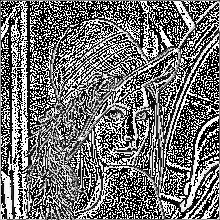

In [8]:
kernel_one_channel = np.array([[0.1, 0.1, 0.1], [0.1, -0.8, 0.1], [0.1, 0.1, 0.1]])
kernel = np.stack([kernel_one_channel] * 3, axis=2)
stride = 1
output = conv(inputs, kernel, stride)
to_image(output, grey=True, save_path="./plots/conv/lenna_conv.png")

### 卷积可视化以及三种不同的模式（FULL、VALID、SAME）

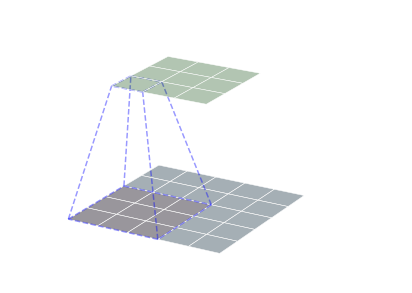

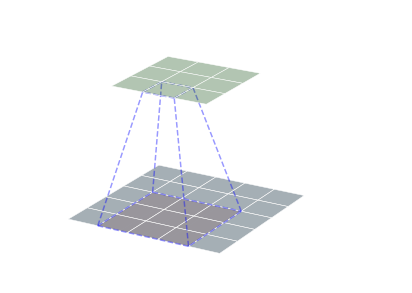

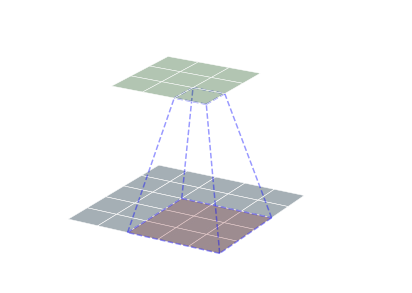

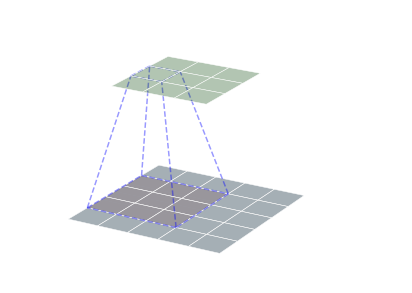

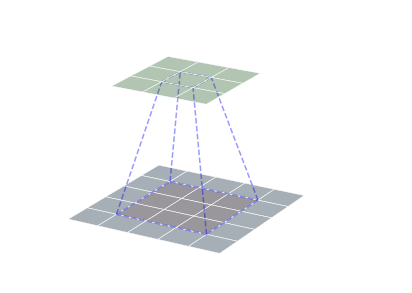

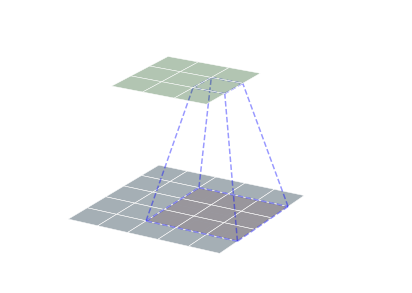

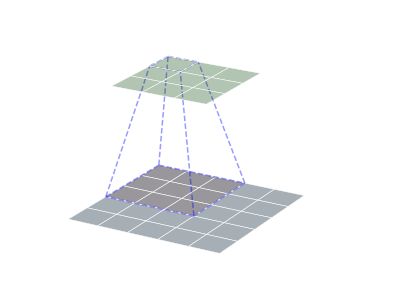

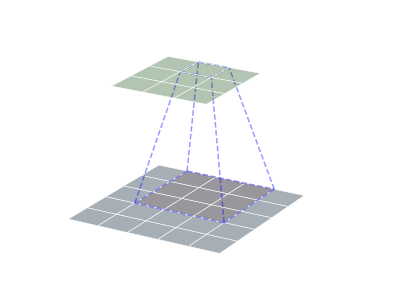

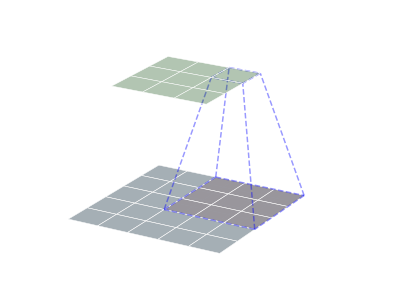

In [9]:
def plot_conv(array, ks, stride=1, offset_x=0, offset_y=0, mode="SAME", connect=False, name="conv", gap=6):
    height, width, channels = array.shape
    pad = get_padding(array, ks, mode)
    
    fig = plt.figure(figsize=(7, 5))
    ax = fig.gca(projection='3d')
    ax._axis3don = False
    ax.set_zlim3d(0, gap)
    max_size = max(height + pad[1] + pad[3], width + pad[0] + pad[2])
    ax.set_ylim(0, max_size + 1)
    ax.set_xlim(0, max_size + 1)

    # input surface
    x = np.linspace(0, width, width + 1)
    y = np.linspace(0, height, height + 1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)
    surf = ax.plot_surface(X, Y, Z, alpha=0.3)

    # padding surface
    x = np.linspace(-pad[0], width + pad[2], width + 1 + pad[0] + pad[2])
    y = np.linspace(-pad[1], height + pad[3], height + 1 + pad[1] + pad[3])
    X,Y = np.meshgrid(x,y)
    Z = np.zeros_like(X)
    surf = ax.plot_surface(X, Y, Z, alpha=0.3, color="white", lw=0.5, edgecolors="white")
    
    # lines
    sx, sy, sz = -pad[0] + offset_x, -pad[1] + offset_y, 0
    p1 = (sx, sy, sz)
    p2 = (sx, sy + ks[1], sz)
    p3 = (sx + ks[0], sy + ks[1], sz)
    p4 = (sx + ks[0], sy, sz)
    frame_line(ax, p1, p2)
    frame_line(ax, p2, p3)
    frame_line(ax, p3, p4)
    frame_line(ax, p4, p1)
    
    x = np.linspace(sx, sx + ks[0], sx + ks[0] + 1)
    y = np.linspace(sy, sy + ks[1], sy + ks[1] + 1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros_like(X) + sz
    surf = ax.plot_surface(X, Y, Z, alpha=0.2, color="red")
    
    # output surface
    res_x_len = int((width + pad[0] + pad[2] - ks[0]) / stride + 1)
    res_y_len = int((height + pad[1] + pad[3] - ks[1]) / stride + 1)
    center_x = (width) / 2
    center_y = (height) / 2
    
    x = np.linspace(center_x - res_x_len / 2, center_x + res_x_len / 2, res_x_len + 1)
    y = np.linspace(center_y - res_y_len / 2, center_y + res_y_len / 2, res_y_len + 1)
    X,Y = np.meshgrid(x,y)
    Z = np.zeros_like(X) + gap
    surf = ax.plot_surface(X, Y, Z, alpha=0.3, color="green", lw=0.5, edgecolors="white")

    sx, sy, sz = center_x - res_x_len / 2 + offset_x, center_y - res_y_len / 2 + offset_y, gap
    p1_ = (sx, sy, sz)
    p2_ = (sx, sy + 1, sz)
    p3_ = (sx + 1, sy + 1, sz)
    p4_ = (sx + 1, sy, sz)
    frame_line(ax, p1_, p2_)
    frame_line(ax, p2_, p3_)
    frame_line(ax, p3_, p4_)
    frame_line(ax, p4_, p1_)

    if connect:
        frame_line(ax, p1, p1_)
        frame_line(ax, p2, p2_)
        frame_line(ax, p3, p3_)
        frame_line(ax, p4, p4_)
        
#     plt.title(name + " (%d, %d) -> (%d, %d)" % (height, width, res_y_len, res_x_len))
    plt.savefig("./plots/conv/%s.png" % name)
    
def frame_line(ax, p1, p2, alpha=0.4):
    line_color = "blue"
    lw = 1.5
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], zs=[p1[2], p2[2]], lw=lw, color=line_color, alpha=alpha, linestyle='--')
    
    
inputs = np.random.randint(0, 20, (5, 5, 3))
stride = 1
ks = [3, 3]
mode = "VALID"
pad = get_padding(inputs, ks, mode=mode)
height, width, channels = inputs.shape
res_width = int((width + pad[0] + pad[2] - ks[0]) / stride + 1)
res_height = int((height + pad[1] + pad[3] - ks[1]) / stride + 1)
for y in range(res_height):
    for x in range(res_width):
        plot_conv(inputs, ks=ks, stride=stride, offset_x=x, offset_y=y, mode=mode, connect=True, name="%s%s" % (x, y))

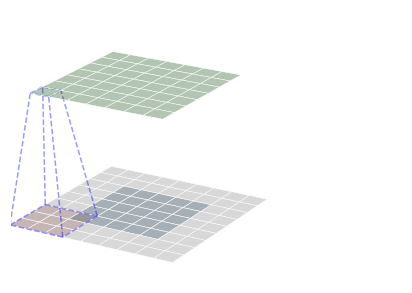

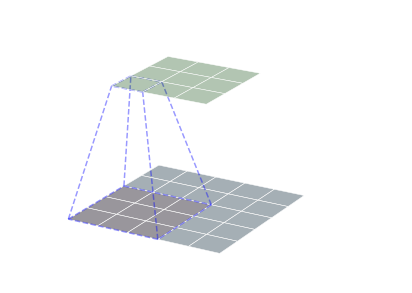

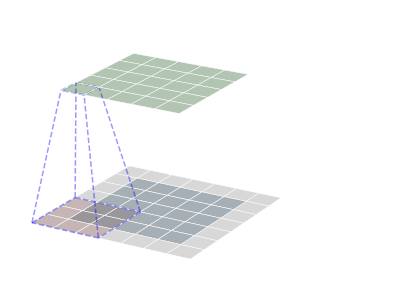

In [10]:
inputs = np.random.randint(0, 20, (5, 5, 3))
stride = 1
ks = [3, 3]
plot_conv(inputs, ks=ks, mode="FULL", stride=stride, name="FULL", connect=True)
plot_conv(inputs, ks=ks, mode="VALID", stride=stride, name="VALID", connect=True)
plot_conv(inputs, ks=ks, mode="SAME", stride=stride, name="SAME", connect=True)

#### 卷积计算优化：转化为矩阵相乘

In [11]:
def conv_matmul(inputs, kernel, stride, mode="SAME"):
    ks = kernel.shape[:2]
    
    pad = get_padding(inputs, ks, mode=mode)
    padded_inputs = np.pad(inputs, pad_width=((pad[0], pad[2]), (pad[1], pad[3]), (0, 0)), mode="constant")

    height, width, channels = inputs.shape
    out_width = int((width + pad[0] + pad[2] - ks[0]) / stride + 1)
    out_height = int((height + pad[1] + pad[3] - ks[1]) / stride + 1)
    
    rearrange = []
    for y in range(0, padded_inputs.shape[0]-ks[1]+1, stride):
        for x in range(0, padded_inputs.shape[1]-ks[0]+1, stride):
            patch = padded_inputs[y:y+ks[1], x:x+ks[0], :]
            rearrange.append(patch.ravel())
    rearrange = np.asarray(rearrange).T
    kernel = kernel.reshape(1, -1)
    return np.matmul(kernel, rearrange).reshape(out_height, out_width)

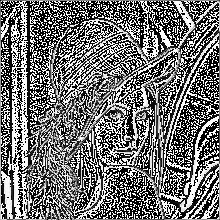

In [12]:
inputs = from_image("./Lenna_test_image.png")
to_image(inputs, save_path="./plots/conv/lenna_origin.png")

#  Embossing Filter
kernel_one_channel = np.array([[0.1, 0.1, 0.1], [0.1, -0.8, 0.1], [0.1, 0.1, 0.1]])
kernel = np.stack([kernel_one_channel] * 3, axis=2)
stride = 1
output = conv_matmul(inputs, kernel, stride)
to_image(output, grey=True, save_path="./plots/conv/lenna_conv.png")

In [13]:
n = 5

start = time.time()
for _ in range(n):
    output = conv(inputs, kernel, stride=1)
cost1 = float((time.time() - start) / n)
print("raw time cost: %.4fs" % cost1)

start = time.time()
for _ in range(n):
    output = conv_matmul(inputs, kernel, stride=1)
cost2 = float((time.time() - start) / n)
print("optimized time cost: %.4fs" % cost2)

reduce = 100 * (cost1 - cost2) / cost1
print("reduce %.2f%% time cost" % reduce)

raw time cost: 0.7339s
optimized time cost: 0.1670s
reduce 77.25% time cost


#### 卷积的梯度计算

#### 反向传播实现

In [14]:
# Dataset Four-Shapes (https://www.kaggle.com/smeschke/four-shapes)
# This dataset contains 16,000 images of four shapes; square, star, circle, and triangle. Each image is 200x200 pixels.
# We down sample each image to 20x20 pixel. For each shape we sample 2,500 images.(10,000 images in total)

shape_list = ["circle", "square", "star", "triangle"]
X, X_flatten, y = list(), list(), list()
for i, shape in enumerate(shape_list):
    file_list = glob.glob("./shapes/%s/*.png" % shape)
    samples = np.random.choice(file_list, 2500)
    for path in samples:
        data = from_image(path)[::10, ::10]
        data = data / 127.5 - 1
        X.append(data)
        X_flatten.append(np.ravel(data))
        y.append(i)

In [15]:
X, X_flatten, y = np.asarray(X), np.asarray(X_flatten), np.asarray(y).reshape(-1, 1)
train_X, test_X, train_X_flatten, test_X_flatten, train_y, test_y = train_test_split(X, X_flatten, y)
print(train_X.shape)
print(test_X.shape)
print(train_X_flatten.shape)
print(test_X_flatten.shape)
print(train_y.shape)
print(test_y.shape)

(7500, 20, 20)
(2500, 20, 20)
(7500, 400)
(2500, 400)
(7500, 1)
(2500, 1)


##### FC with one hidden layer

In [16]:
in_dim = 20 * 20
out_dim = 4
hidden_dim = 100

def build_fc(in_dim, out_dim, hidden_dim):
    bound1 = np.sqrt(6.0 / (in_dim + hidden_dim))
    W1 = np.random.uniform(-bound1, bound1, size=[in_dim, hidden_dim])
    b1 = np.zeros(hidden_dim)
    bound2 = np.sqrt(6.0 / (hidden_dim + out_dim))
    W2 = np.random.uniform(-bound2, bound2, size=[hidden_dim, out_dim])
    b2 = np.zeros(out_dim)
    return [W1, b1, W2, b2]

def softmax(inputs):
    return np.exp(inputs) / np.sum(np.exp(inputs), 1)[:, None]

def fc_propagate(batch_X, batch_y, params):
    # one-hot label
    labels = np.zeros((len(batch_X), out_dim))
    for i in range(len(batch_y)):
        labels[i][batch_y[i]] = 1.0
    # forward
    W1, b1, W2, b2 = params
    h1 = np.dot(batch_X, W1) + b1
    a1 = np.copy(h1)
    a1[a1 < 0.0] = 0.0
    h2 = np.dot(a1, W2) + b2
    p = softmax(h2)
    # NLL loss
    loss = np.mean(-np.log(np.sum(p * labels, 1)))
    # backward
    dl_dh2 = p - labels  # [batch, out_dim]
    dl_dW2 = np.dot(a1.T, dl_dh2)
    dl_db2 = np.sum(dl_dh2, 0)
    dl_da1 = np.dot(dl_dh2, W2.T)
    da1_dh1 = (h1 > 0).astype(float)
    dl_dh1 = dl_da1 * da1_dh1
    dl_dW1 = np.dot(batch_X.T, dl_dh1)
    dl_db1 = np.sum(dl_dh1, 0)
    return p, loss, [dl_dW1, dl_db1, dl_dW2, dl_db2]

In [17]:
batch_size = 32
leanring_rate = 0.003
running_loss = 0
params = build_fc(in_dim, out_dim, hidden_dim)
for step in range(5000):
    batch_idx = np.random.randint(0, len(train_X_flatten), size=batch_size)
    batch_X, batch_y = train_X_flatten[batch_idx], train_y[batch_idx]
    _, loss, grads = fc_propagate(batch_X, batch_y, params)
    if running_loss:
        running_loss = 0.9 * running_loss + 0.1 * loss
    else:
        running_loss = loss
    # update params
    for i in range(len(params)):
        params[i] -= leanring_rate * grads[i]
    if step % 1000 == 0:
        print(step, running_loss)
# evaluate
predict, eval_loss, _ = fc_propagate(test_X_flatten, test_y, params)
predict = np.argmax(predict, 1)
count = 0.0
for i in range(len(test_y)):
    if predict[i] == test_y[i][0]:
        count += 1.0
print("eval loss: ", eval_loss)
print("eval accu: ", (count / len(test_y)))

0 1.7189790235358715
1000 0.00469358085976106
2000 0.0026256160621620493
3000 0.0010848400949145772
4000 0.0007815376833262583
eval loss:  0.0014050687031707042
eval accu:  0.9992


##### TODO: one layer conv